In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import re, string, time, random
import matplotlib.pyplot as plt
from PIL import Image
from kaggle_datasets import KaggleDatasets
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pathlib
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from nltk.corpus import stopwords

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [9]:
train_df = pd.read_csv(r'/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='latin1')
test_df = pd.read_csv(r'/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding='latin1')

In [10]:
def data_cleansing(corpus):
    corpus = re.sub(r'http\S+', ' ', corpus)
    corpus = re.sub(r'<.*?>',' ', corpus)
    corpus = re.sub(r'\d+',' ', corpus)
    corpus = re.sub(r'#\w+',' ', corpus)
    corpus = re.sub(r'@\w+',' ', corpus)
    corpus = corpus.split()
    corpus = " ".join([word for word in corpus if not word in stop_words])
    return corpus

stop_words = stopwords.words('english')
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(data_cleansing)

In [11]:
def dict_cate(df):
    dict_cate = {}
    for i, cate in enumerate(set(df.values)):
        dict_cate[cate] = i
    return dict_cate
dict_cate = dict_cate(train_df['Sentiment'])
dict_cate['Extremely Negative']=0
dict_cate['Neutral']=1
dict_cate['Extremely Positive']=2
dict_cate['Positive']=2
dict_cate['Negative']=0
dict_cate

{'Extremely Negative': 0,
 'Neutral': 1,
 'Negative': 0,
 'Extremely Positive': 2,
 'Positive': 2}

In [12]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: dict_cate[x])

In [7]:
#TextVectorization
vocab_size=10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)
encoder.adapt(all_df.map(lambda text: text))
def encoder_fn(text, label):
  text = tf.expand_dims(text, -1)
  return encoder(text), label
dataset = dataset.map(encoder_fn)

NameError: name 'all_df' is not defined

In [13]:
#Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_df['OriginalTweet'])
train_df['OriginalTweet'] = tokenizer.texts_to_sequences(train_df['OriginalTweet'])
vocab_size = len(tokenizer.word_index)+1
train_Tweet = pad_sequences(train_df['OriginalTweet'], padding='post')

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=train_Tweet.shape[1]), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])

In [15]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
history = model.fit(train_Tweet, train_df['Sentiment'].values, validation_split=0.1
                    , batch_size=64, epochs=10, shuffle=True)

Epoch 1/10
579/579 [==============================] - 149s 257ms/step - loss: 0.6335 - accuracy: 0.7306 - val_loss: 0.3717 - val_accuracy: 0.8771
Epoch 2/10
579/579 [==============================] - 147s 254ms/step - loss: 0.3019 - accuracy: 0.9022 - val_loss: 0.3611 - val_accuracy: 0.8744
Epoch 3/10
579/579 [==============================] - 147s 255ms/step - loss: 0.2039 - accuracy: 0.9373 - val_loss: 0.3843 - val_accuracy: 0.8737
Epoch 4/10
579/579 [==============================] - 147s 254ms/step - loss: 0.1529 - accuracy: 0.9519 - val_loss: 0.4572 - val_accuracy: 0.8652
Epoch 5/10
579/579 [==============================] - 147s 254ms/step - loss: 0.1170 - accuracy: 0.9627 - val_loss: 0.5190 - val_accuracy: 0.8554
Epoch 6/10
579/579 [==============================] - 148s 255ms/step - loss: 0.0873 - accuracy: 0.9720 - val_loss: 0.6580 - val_accuracy: 0.8319
Epoch 7/10
579/579 [==============================] - 148s 256ms/step - loss: 0.0651 - accuracy: 0.9798 - val_loss: 0.6985 -

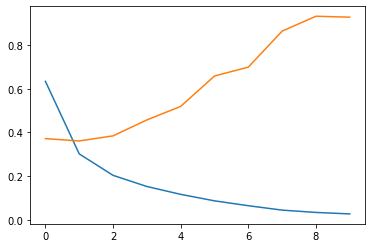

In [19]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'])
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'])

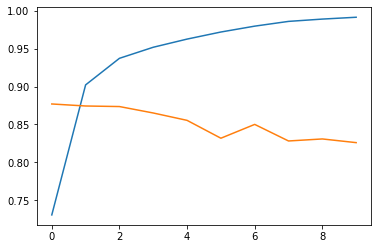

In [20]:
plt.plot(np.arange(len(history.history['loss'])), history.history['accuracy'])
plt.plot(np.arange(len(history.history['loss'])), history.history['val_accuracy'])

In [22]:
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(data_cleansing)
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: dict_cate[x])
test_df['OriginalTweet'] = tokenizer.texts_to_sequences(test_df['OriginalTweet'])
test_Tweet = pad_sequences(test_df['OriginalTweet'], padding='post')
test_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"[2797, 36, 5252, 6543, 152, 6, 56, 7792, 5945,...",0
1,2,44954,"Seattle, WA",02-03-2020,"[196, 2, 136, 30, 27, 5651, 6366, 2, 1705, 127...",2
2,3,44955,NaN,02-03-2020,"[136, 223, 1671, 678]",2
3,4,44956,Chicagoland,02-03-2020,"[35, 1388, 430, 2341, 281, 31, 5, 9, 212, 120,...",0
4,5,44957,"Melbourne, Victoria",03-03-2020,"[122, 14583, 33, 86, 77, 35, 997, 353, 5530, 1...",1
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,"[1431, 39, 45, 6, 5857, 8, 4498, 7557, 302, 48...",2
3794,3795,48747,"Farmington, NM",16-03-2020,"[817, 18, 52, 274, 428, 2615, 115, 8509, 219, ...",0
3795,3796,48748,"Haverford, PA",16-03-2020,"[4649, 3033, 900, 640, 647, 15526, 107, 200, 4...",1
3796,3797,48749,NaN,16-03-2020,"[849, 16, 16595, 413, 11470, 3305, 29079, 3987...",0


In [23]:
test_history = model.evaluate(test_Tweet, test_df['Sentiment'])

119/119 [==============================] - 5s 46ms/step - loss: 1.0174 - accuracy: 0.8091
